In [1]:
import os
from glob import glob
import pandas as pd
import json
import numpy as np
from matplotlib import pyplot as plt 

In [2]:
# Setting

analysis_dir = r"/home/yiting/Documents/Analysis"
data_dir = r"/media/yiting/NewVolume/Data/Videos"
session_name = "2024-12-06"
ap_dir = os.path.join(analysis_dir, session_name, "anipose")
angle_dir = os.path.join(ap_dir,"angles")
angle_trials = sorted(glob(os.path.join(angle_dir, "*.csv")))
log_dir = os.path.join(data_dir, session_name, "trial_logs")
log_trials = sorted(glob(os.path.join(log_dir, "*.json")))
frame_number = 300

save_dir = os.path.join(analysis_dir,"hand_config")


In [3]:
# Create a table
# 1. Extract angles from the holding time
# 2. Add trial name and shape id
df = pd.DataFrame()
for log_trial,angle_trial in zip(log_trials, angle_trials):
    
    angle_df = pd.read_csv(os.path.join(angle_dir, angle_trial))
    # Open and read the JSON file
    with open(os.path.join(log_dir, log_trial), 'r') as file:
        json_data = json.load(file)

    new_df = angle_df.loc[[frame_number]]
    new_df["trial_name"] = log_trial[11:19]
    new_df["shape_id"] = json_data["shape_id"]
    new_df["correct"] = json_data["has_played_success_tone"]
    new_df["is_holdshort"] = json_data["object_released"]
    new_df["is_holdlong"] = json_data["object_held"]
    new_df["is_sameShape"] = json_data["reward_direction"] == 'holdshort'

    df = pd.concat([df,new_df])
    
df.reset_index(drop=True, inplace=True)


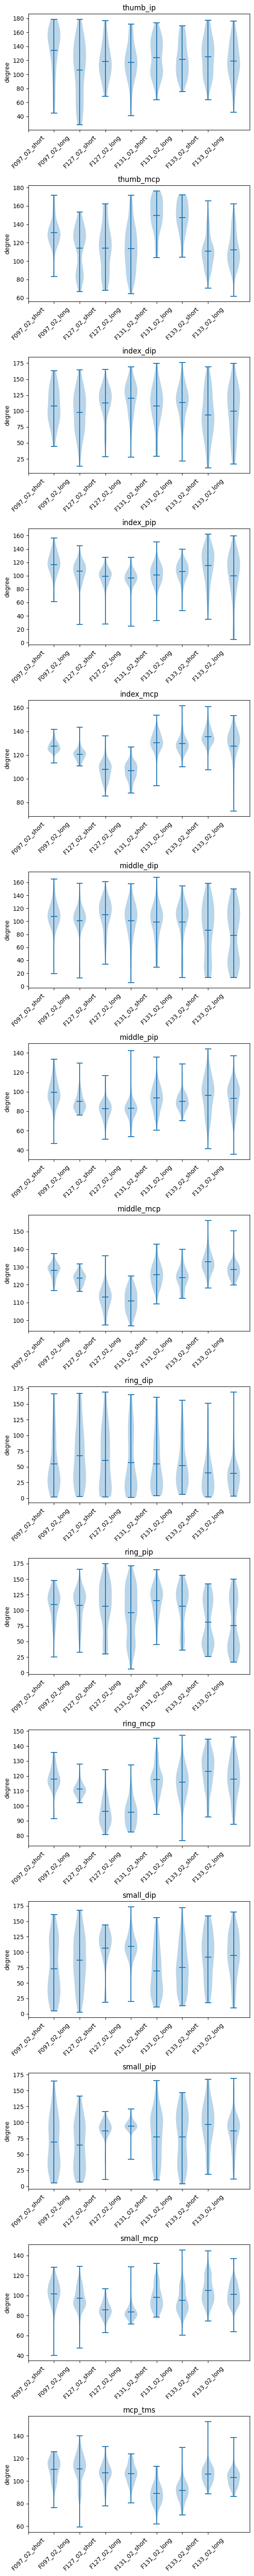

In [4]:
shape_names = np.unique(df.shape_id)
angle_names = df.columns[0:15]

fig, axs = plt.subplots(len(angle_names),1, figsize=(6, 4*len(angle_names)))
for a, angle_name in enumerate(angle_names): 
    data_dict = {}  # Dictionary to store category data
    for s, shape_name in enumerate(shape_names):
        
        # for short correct trials
        data1 = df.query('shape_id == @shape_name and correct == @True and is_holdshort ==@True') 
        data2 = data1[angle_name].values
        data_dict[shape_name + '_short'] = data2[~np.isnan(data2)] 
        # for long correct trials
        data3 = df.query('shape_id == @shape_name and correct == @True and is_holdlong ==@True') 
        data4 = data3[angle_name].values
        data_dict[shape_name + '_long'] = data4[~np.isnan(data4)]
    # Convert dictionary values to a list of arrays for plotting
    data_list = list(data_dict.values())

    axs[a].violinplot(data_list, showmeans=True)
    axs[a].set_title(angle_name)
    axs[a].set_ylabel('degree')
    axs[a].set_xticks(range(0, len(list(data_dict.keys()))),labels = list(data_dict.keys()), rotation = 45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(save_dir, session_name + "_hand_config_correct.png"))